# 增强边缘

In [2]:
path = "/workspace/models/SAHI/run_v9/ElderFarm1_0625/images/autofocus_rpicam_still/20250620_141212_Center.jpg"

In [3]:
in_paths = [
    # "/mnt/data/334b0994-4395-4105-9c4e-0731c3b60441.png",
    # "/mnt/data/4c2f7d60-45f7-413f-8eb2-74731264cd35.png",
    path
]

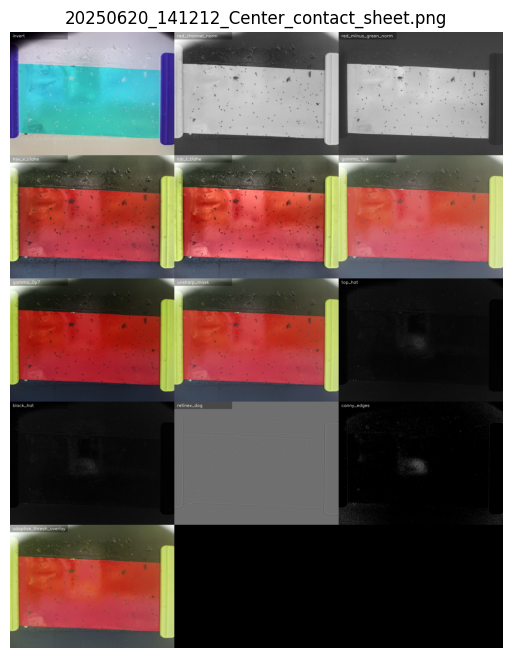

'/workspace/models/SAHI/run_v9/swd_enhanced/swd_enhanced_outputs.zip'

In [ ]:
# This script loads two provided trap images, applies a suite of enhancement methods
# to make insect-vs-background boundaries clearer, and saves both individual results
# and contact sheets for quick comparison. All outputs go to /mnt/data/swd_enhanced.
#
# Methods included:
# - invert
# - red_channel_norm
# - red_minus_green_norm
# - hsv_v_clahe
# - lab_l_clahe
# - gamma_1p4 (brighten mids)
# - gamma_0p7 (darken mids)
# - unsharp_mask
# - top_hat (morphological white tophat)
# - black_hat (emphasize dark blobs)
# - retinex_dog (difference-of-gaussians as a simple Retinex)
# - canny_edges
# - adaptive_thresh_overlay (binary mask overlay)
#
# It also exports a ZIP with all results for easy download.

import os
import cv2
import numpy as np
from PIL import Image, ImageOps, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import zipfile

# ---------- Paths ----------

out_dir = "/workspace/models/SAHI/run_v9/swd_enhanced"
os.makedirs(out_dir, exist_ok=True)

# ---------- Utilities ----------
def to_uint8(img):
    img = np.clip(img, 0, 255)
    return img.astype(np.uint8)

def ensure_3c(img):
    if img.ndim == 2:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def overlay_mask(base_bgr, mask, alpha=0.45, color=(0,255,255)):
    base = base_bgr.copy()
    overlay = base.copy()
    overlay[mask>0] = color
    return cv2.addWeighted(overlay, alpha, base, 1-alpha, 0)

def put_label(img_bgr, text):
    img = img_bgr.copy()
    h, w = img.shape[:2]
    pad = 6
    # semi-transparent label box
    box_w = min(w, max(120, int(0.35*w)))
    box_h = 28
    overlay = img.copy()
    cv2.rectangle(overlay, (0,0), (box_w, box_h), (0,0,0), -1)
    img = cv2.addWeighted(overlay, 0.35, img, 0.65, 0)
    cv2.putText(img, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255,255,255), 1, cv2.LINE_AA)
    return img

# ---------- Enhancement Methods ----------
def enhance_methods(bgr):
    methods = {}
    h, w = bgr.shape[:2]

    # 1) Invert
    inv = cv2.bitwise_not(bgr)
    methods["invert"] = inv

    # 2) Red channel normalized
    r = bgr[:,:,2].astype(np.float32)
    r_norm = cv2.normalize(r, None, 0, 255, cv2.NORM_MINMAX)
    methods["red_channel_norm"] = cv2.cvtColor(to_uint8(r_norm), cv2.COLOR_GRAY2BGR)

    # 3) R-G normalized (helps highlight dark insects on red boards)
    g = bgr[:,:,1].astype(np.float32)
    rg = r - g
    rg_norm = cv2.normalize(rg, None, 0, 255, cv2.NORM_MINMAX)
    methods["red_minus_green_norm"] = cv2.cvtColor(to_uint8(rg_norm), cv2.COLOR_GRAY2BGR)

    # 4) HSV V channel + CLAHE
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    v = hsv[:,:,2]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v_eq = clahe.apply(v)
    hsv2 = hsv.copy()
    hsv2[:,:,2] = v_eq
    methods["hsv_v_clahe"] = cv2.cvtColor(hsv2, cv2.COLOR_HSV2BGR)

    # 5) LAB L channel + CLAHE
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    l = lab[:,:,0]
    l_eq = clahe.apply(l)
    lab2 = lab.copy()
    lab2[:,:,0] = l_eq
    methods["lab_l_clahe"] = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

    # 6) Gamma correction (brighten mids)
    def gamma_corr(img, gamma):
        invGamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
        return cv2.LUT(img, table)
    methods["gamma_1p4"] = gamma_corr(bgr, 1.4)
    methods["gamma_0p7"] = gamma_corr(bgr, 0.7)

    # 7) Unsharp mask
    blur = cv2.GaussianBlur(bgr, (0,0), sigmaX=1.2)
    usm = cv2.addWeighted(bgr, 1.6, blur, -0.6, 0)
    methods["unsharp_mask"] = usm

    # 8) Morphological Top-hat (white small bright spots)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31,31))
    top_hat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    methods["top_hat"] = cv2.cvtColor(to_uint8(top_hat), cv2.COLOR_GRAY2BGR)

    # 9) Black-hat (small dark blobs on bright background)
    black_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    methods["black_hat"] = cv2.cvtColor(to_uint8(black_hat), cv2.COLOR_GRAY2BGR)

    # 10) Retinex via Difference of Gaussians on grayscale, then normalize
    g1 = cv2.GaussianBlur(gray, (0,0), 3)
    g2 = cv2.GaussianBlur(gray, (0,0), 15)
    dog = cv2.normalize((g1.astype(np.float32) - g2.astype(np.float32)), None, 0, 255, cv2.NORM_MINMAX)
    methods["retinex_dog"] = cv2.cvtColor(to_uint8(dog), cv2.COLOR_GRAY2BGR)

    # 11) Canny edges
    v_med = np.median(gray)
    lower = int(max(0, 0.66*v_med))
    upper = int(min(255, 1.33*v_med))
    edges = cv2.Canny(gray, lower, upper)
    methods["canny_edges"] = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # 12) Adaptive threshold -> overlay
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 35, 7)
    overlay = overlay_mask(bgr, thr, alpha=0.45, color=(0,255,255))
    methods["adaptive_thresh_overlay"] = overlay

    return methods

# ---------- Process & Save ----------
contact_sheets = []
all_saved = []
for path in in_paths:
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        print(f"Failed to read {path}")
        continue
    name = os.path.splitext(os.path.basename(path))[0]
    methods = enhance_methods(bgr)

    # Save individual results
    indiv_dir = os.path.join(out_dir, name)
    os.makedirs(indiv_dir, exist_ok=True)
    for mname, img in methods.items():
        labeled = put_label(ensure_3c(img), mname)
        save_path = os.path.join(indiv_dir, f"{name}_{mname}.png")
        cv2.imwrite(save_path, labeled)
        all_saved.append(save_path)

    # Build contact sheet (3 cols x N rows)
    keys = list(methods.keys())
    cols = 3
    thumb_w = 640
    scale = thumb_w / bgr.shape[1]
    thumb_h = int(bgr.shape[0] * scale)
    thumbs = []
    for k in keys:
        im = ensure_3c(methods[k])
        im_resized = cv2.resize(im, (thumb_w, thumb_h), interpolation=cv2.INTER_AREA)
        im_resized = put_label(im_resized, k)
        thumbs.append(im_resized)

    rows = int(np.ceil(len(thumbs)/cols))
    sheet_h = rows*thumb_h
    sheet_w = cols*thumb_w
    sheet = np.zeros((sheet_h, sheet_w, 3), dtype=np.uint8)
    for idx, th in enumerate(thumbs):
        r = idx // cols
        c = idx % cols
        sheet[r*thumb_h:(r+1)*thumb_h, c*thumb_w:(c+1)*thumb_w, :] = th

    contact_path = os.path.join(out_dir, f"{name}_contact_sheet.png")
    cv2.imwrite(contact_path, sheet)
    contact_sheets.append(contact_path)
    all_saved.append(contact_path)

# ---------- Zip outputs ----------
zip_path = os.path.join(out_dir, "swd_enhanced_outputs.zip")
with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for f in all_saved:
        arcname = os.path.relpath(f, out_dir)
        zf.write(f, arcname)

# ---------- Display contact sheets ----------
for cp in contact_sheets:
    img = cv2.cvtColor(cv2.imread(cp), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(cp))
plt.show()

zip_path


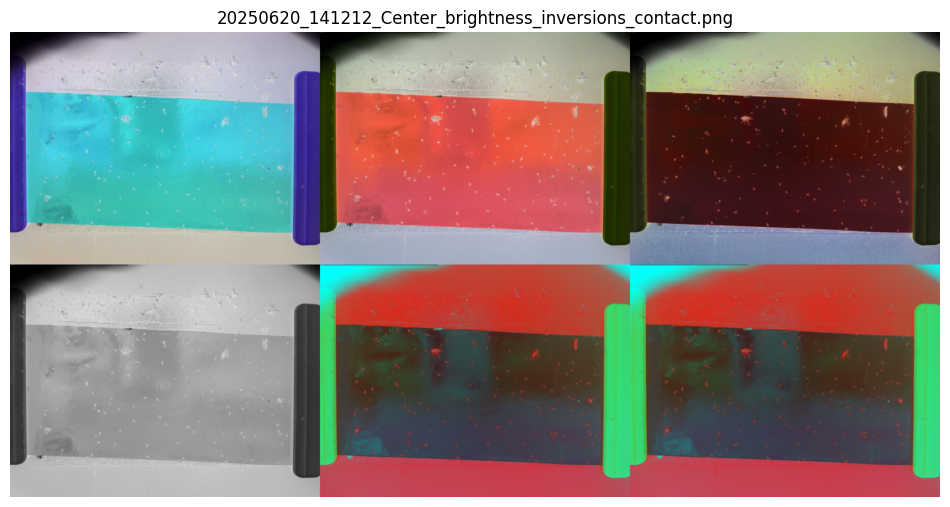

'/workspace/models/SAHI/run_v9/swd_enhanced2/swd_enhanced_brightness_inversions.zip'

In [6]:
# Add additional "brightness inversion" variants focusing on lightness/value only,
# plus R-only invert. Re-run for the same two images and save outputs alongside previous ones.

import os, cv2, numpy as np, matplotlib.pyplot as plt, zipfile


out_dir = "/workspace/models/SAHI/run_v9/swd_enhanced2"
os.makedirs(out_dir, exist_ok=True)

def ensure_3c(img):
    if img.ndim == 2:
        return cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img

def put_label(img_bgr, text):
    img = img_bgr.copy()
    h, w = img.shape[:2]
    overlay = img.copy()
    cv2.rectangle(overlay, (0,0), (int(0.38*w), 28), (0,0,0), -1)
    img = cv2.addWeighted(overlay, 0.35, img, 0.65, 0)
    cv2.putText(img, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255,255,255), 1, cv2.LINE_AA)
    return img

def add_method(methods, name, img):
    methods[name] = put_label(ensure_3c(img), name)

def brightness_inversions(bgr):
    methods = {}
    # 1) RGB full invert (already had) for reference
    add_method(methods, "invert_rgb", cv2.bitwise_not(bgr))

    # 2) LAB L-channel invert (lightness inversion only)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    L_inv = 255 - L
    lab_inv = cv2.merge([L_inv, A, B])
    add_method(methods, "invert_L_in_LAB", cv2.cvtColor(lab_inv, cv2.COLOR_LAB2BGR))

    # 3) HSV V-channel invert (value inversion only)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    V_inv = 255 - V
    hsv_inv = cv2.merge([H, S, V_inv])
    add_method(methods, "invert_V_in_HSV", cv2.cvtColor(hsv_inv, cv2.COLOR_HSV2BGR))

    # 4) Grayscale invert (luminance only)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray_inv = 255 - gray
    add_method(methods, "invert_grayscale", cv2.cvtColor(gray_inv, cv2.COLOR_GRAY2BGR))

    # 5) R-channel only inversion (red board polarity flip)
    b, g, r = cv2.split(bgr)
    r_inv = 255 - r
    add_method(methods, "invert_R_only", cv2.merge([b, g, r_inv]))

    # 6) R-channel invert + slight unsharp (often closest to “polarity flip” look)
    r_only_inv = cv2.merge([b, g, r_inv])
    blur = cv2.GaussianBlur(r_only_inv, (0,0), 1.2)
    usm = cv2.addWeighted(r_only_inv, 1.6, blur, -0.6, 0)
    add_method(methods, "invert_R_only_usm", usm)

    return methods

# Process
sheet_paths = []
saved = []
for p in in_paths:
    bgr = cv2.imread(p, cv2.IMREAD_COLOR)
    methods = brightness_inversions(bgr)

    base = os.path.splitext(os.path.basename(p))[0]
    sub = os.path.join(out_dir, base)
    os.makedirs(sub, exist_ok=True)
    # save individuals and compose contact sheet
    thumbs = []
    cols = 3
    tw = 640
    scale = tw / bgr.shape[1]
    th = int(bgr.shape[0]*scale)

    for name, img in methods.items():
        save_path = os.path.join(sub, f"{base}_{name}.png")
        cv2.imwrite(save_path, img)
        saved.append(save_path)
        th_img = cv2.resize(img, (tw, th), interpolation=cv2.INTER_AREA)
        thumbs.append(th_img)

    rows = int(np.ceil(len(thumbs)/cols))
    sheet = np.zeros((rows*th, cols*tw, 3), dtype=np.uint8)
    for i, timg in enumerate(thumbs):
        r = i//cols; c = i%cols
        sheet[r*th:(r+1)*th, c*tw:(c+1)*tw] = timg
    sheet_path = os.path.join(out_dir, f"{base}_brightness_inversions_contact.png")
    cv2.imwrite(sheet_path, sheet)
    sheet_paths.append(sheet_path)
    saved.append(sheet_path)

# Zip
zip_path = os.path.join(out_dir, "swd_enhanced_brightness_inversions.zip")
with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for f in saved:
        zf.write(f, os.path.relpath(f, out_dir))

# Display sheets
for cp in sheet_paths:
    img = cv2.cvtColor(cv2.imread(cp), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,8)); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(cp))
plt.show()

zip_path
